C:\Users\Jun\anaconda3\lib\site-packages\ipykernel_launcher.py:137: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)
HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=7, min_samples=None, p=None,
        prediction_data=True) 6
label :  [0 1 2 3 4 5]
Input Dimension:  (1520, 2)
Output Dimension:  (1520,)
y2 :  [5 5 5 ... 5 5 5] 
y2.bincount :  [ 178    5   16   25   27 1269]
maxLabel:  5 maxLabelcount :  1269
values:  [0.8 1.  1.2] counts:  [ 178   73 1269]
0 시간, 승객 수:  1520 , 운전자 수:  1154 



C:\Users\Jun\anaconda3\lib\site-packages\ipykernel_launcher.py:156: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


episode: 0   score: 3780  global_step: 1   epsilon: 0.9999
episode: 0   score: 4240  global_step: 101   epsilon: 0.989950333757503
4400 [array(0.04131368), 0.0, array(0.053291), array(0.02661926), array(0.02475846)]
episode: 0   score: 4540  global_step: 201   epsilon: 0.9800996732739187
4360 [array(0.01429233), array(0.02710882), array(0.01358558), array(0.01351364), 0.0]
episode: 0   score: 4700  global_step: 301   epsilon: 0.9703470333764725
4840 [0.0, 0.0, 0.0, 0.0, 0.0]
4780 [0.0, array(0.02083251), 0.0, 0.0, 0.0]
4760 [array(0.01086133), 0.0, array(0.0517267), array(0.02006946), array(0.00991816)]
4760 [array(0.01086133), 0.0, array(0.06200417), array(0.02006946), array(0.00991816)]
5400 [0.0, 0.0, 0.0, 0.0, 0.0]
episode: 0   score: 4740  global_step: 401   epsilon: 0.9606914386955115
4680 [0.0, 0.0, array(0.04308849), array(0.01081417), array(0.01042695)]
4400 [array(0.05493335), 0.0, array(0.10597474), array(0.07912918), array(0.04926347)]
4160 [0.0, array(0.01659932), array(0.

4080 [array(0.11073392), array(0.10293996), array(0.20114938), array(0.06789556), array(0.07974033)]
4140 [array(0.03407906), array(0.16669346), array(0.14440137), array(0.14615903), array(0.03066317)]
4060 [array(0.07602576), array(0.0375926), array(0.07081726), 0.0, array(0.1306212)]
4300 [array(0.06142215), array(0.02860781), array(0.02811437), array(0.0137808), array(0.05266907)]
4060 [array(0.07602576), array(0.0375926), array(0.07081726), 0.0, array(0.16318879)]
4140 [array(0.07011272), array(0.1833371), array(0.14440137), array(0.14615903), array(0.04617365)]
4100 [array(0.12744543), array(0.18604325), array(0.08423607), array(0.08423919), array(0.11026057)]
4080 [array(0.11073392), array(0.11999074), array(0.23434967), array(0.11894762), array(0.07974033)]
4000 [array(0.14322136), array(0.1283158), array(0.16455259), array(0.10997149), array(0.15647884)]
3980 [array(0.10334145), array(0.11519364), array(0.09288441), array(0.18088355), array(0.01778496)]
3920 [array(0.04345939),

KeyboardInterrupt: 

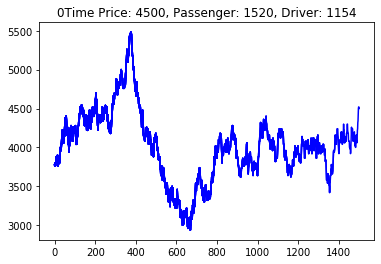

In [2]:
# Q-learning table사용
from cupy import asarray, concatenate, zeros, where, unique, asnumpy, bincount, argmax, \
argpartition, argsort, unravel_index, max as cmax, min as cmin, random as crandom
from numpy import median
from random import choice
from pylab import plot, savefig, title, clf
from collections import defaultdict
from pickle import load
from tqdm import tqdm_notebook
from functions import data_load, randomSampling, trip_Distance, Calculate_distance,\
Calculate_Matrix, myHdbscan, ScaledHdbscan, dbcluster, mat2, pick

INITIALPRICE = 3800

# 환경
class Env:
    def __init__(self):
        self.action_space = ['u', 'l', 'c', 'r', 'd'] # 행동 순서대로 -80, -20, 0, +20, +80
        self.n_actions = len(self.action_space)  # 5 actions
        self.marketPrice = INITIALPRICE          # marketPrice 
        self.PP = None    #Passenger의 선호 가격 리스트
        self.passengers = None #승객의 수 초기 500명
        self.DP = None    #Driver의 선호 가격 리스트
        self.drivers = None    #운전자 수 초기 500명
        self.matrix = None # matching matrix
        self.PD = None
        
    def step(self, action):
        if   action == 0:   # up : price-=80
            self.marketPrice-=80
            
        elif action == 1:   # left : price-=20
            self.marketPrice-=20
            
        elif action == 2:   # center : Nothing happen
            pass
        
        elif action == 3:   # right : price+=20
            self.marketPrice+=20

        elif action == 4:   # down : price+=80
            self.marketPrice+=80


        next_state = self.marketPrice
        reward = 0
        match = 0
        threshold = 0.4   # 기준점 어떻게?
        
        #보상 가격허용치를 넘으면 -100
        if next_state < (INITIALPRICE / 2) or next_state > (INITIALPRICE * 2):
            reward = -100
            
        else:
            """ 방법 2 Matrix 생성 후 뽑기"""
            newMatrix, MIN = mat2(self.PP, self.DP, next_state, self.PD, self.matrix)
            match = pick(newMatrix, MIN)
            reward = (match / 1000) * (next_state / 1000)

        return next_state, reward
        
    def reset(self, PD, matrix):
        self.passengers = matrix.shape[0]
        self.drivers = matrix.shape[1]
        self.PP = crandom.normal(self.marketPrice, self.marketPrice / 20, self.passengers).reshape(-1, 1) #Passenger의 선호 가격 리스트
        self.DP = crandom.normal(self.marketPrice, self.marketPrice / 20, self.drivers) #Driver의 선호 가격 리스트
        # 매칭 매트릭스 초기화
        self.PD = PD
        self.matrix = matrix
            
        return self.marketPrice
        
# 가격 Agent
class priceActionModel:
    def __init__(self, actions):
        # 행동 = [0, 1, 2, 3, 4] 순서대로 -80, -20, 0, +20, +80
        self.load_model = False
        self.actions = actions
        self.learning_rate = None
        self.discount_factor = None
        self.epsilon = 1.  # exploration
        self.epsilon_decay = None
        self.epsilon_min = None
        self.q_table = None # 5열
        
    # <s, a, r, s'> 샘플로부터 큐함수 업데이트
    def learn(self, state, action, reward, next_state):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        q_1 = self.q_table[state][action]
        # 벨만 최적 방정식을 사용한 큐함수의 업데이트
        q_2 = reward + self.discount_factor * max(self.q_table[next_state])
        self.q_table[state][action] += self.learning_rate * (q_2 - q_1)
    
    # 큐함수에 의거하여 입실론 탐욕 정책에 따라서 행동을 반환
    def get_action(self, state):
        if crandom.rand() < self.epsilon:
            
            action = choice(self.actions)
        else:
            # 큐함수에 따른 행동 반환
            print(state, self.q_table[state])
            state_action = self.q_table[state]
            action = self.arg_max(state_action)
        return action
        
    @staticmethod
    def arg_max(state_action):
        max_index_list = []
        max_value = state_action[0]
        for index, value in enumerate(state_action):
            if value > max_value:
                max_index_list.clear()
                max_value = value
                max_index_list.append(index)
            elif value == max_value:
                max_index_list.append(index)
        return choice(max_index_list)
    
    def reset(self):
        self.load_model = False
        self.learning_rate = 0.01
        self.discount_factor = 0.9
        self.epsilon = 1.  # exploration
        self.epsilon_decay = .9999
        self.epsilon_min = 0.01
        self.q_table = defaultdict(lambda: [0.0, 0.0, 0.0, 0.0, 0.0]) # 5열
        
if __name__ == "__main__":
    # Data_load
    dclus, pp, dd = data_load()
    
    env = Env()
    agent = priceActionModel(actions=list(range(env.n_actions)))            # [0, 1, 2, 3, 4]
    
    for episode in tqdm_notebook(range(len(pp))):
        global_step = 0
        scores, episodes = [], []
    
        # 매칭 매트릭스 계산
        PD = Calculate_Matrix(episode, dclus, pp, dd)
        OD = trip_Distance(episode, pp)
        clusterer, labelNum = ScaledHdbscan(episode, pp, cluster_size = 7)
        DS = dbcluster(episode, pp, clusterer, labelNum, k = 3)
        matrix = PD * OD * DS
        
        Passenger = matrix.shape[0]
        Driver = matrix.shape[1]
        print(episode, "시간, 승객 수: ", Passenger, ", 운전자 수: ", Driver, "\n")
        
        state = env.reset(PD, matrix)
        agent.reset()
        print("=============================================================================================")
        
        for i in tqdm_notebook(range(50000)):
            global_step += 1

            # 현재 상태에 대한 행동 선택
            action = agent.get_action(str(state))
            
            # 행동을 취한 후 다음 상태, 보상 에피소드의 종료여부를 받아옴
            next_state, reward = env.step(action)

            # <s,a,r,s'>로 큐함수를 업데이트
            agent.learn(str(state), action, reward, str(next_state))
            state = next_state
            # 모든 큐함수를 화면에 표시
            #env.print_value_all(agent.q_table)
            
            scores.append(state)
            episodes.append(i)
            if((i % 100) == 0):
                plot(episodes, scores, 'b')
#                 if i > 49800:
                title('{}Time Price: {}, Passenger: {}, Driver: {}'.format(episode, state, Passenger, Driver))
                savefig("./Grape/test_{}Time.png".format(episode))
                print("episode:", episode, "  score:", state, " global_step:",
                      global_step, "  epsilon:", agent.epsilon)
        clf()      
